- changed to pre-made tiles from pre-made cropped images 

Original datasets <br>
https://www.kaggle.com/muerbingsha/pandacroppedlevel11 <br>
https://www.kaggle.com/muerbingsha/pandacroppedlevel12 <br>
https://www.kaggle.com/muerbingsha/pandacroppedlevel13 <br>

Changed datasets <br>
https://www.kaggle.com/muerbingsha/pandacroppedlevel1tiles1 <br>
https://www.kaggle.com/muerbingsha/pandacroppedlevel1tiles2 <br>
https://www.kaggle.com/muerbingsha/pandacroppedlevel1tiles3 <br>

Benefits:
git rid or `get_tiles`and `find_tiles` to have faster tiles getting speed

- added accumulation\_step to see if adjusting batch size working

## evaluate on multiple datasets 

In [ ]:
!pip install efficientnet_pytorch

In [1]:
DEBUG = True

In [2]:
import os, random, glob, cv2, gc
from termcolor import colored
import sys
import time
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import albumentations as A

from functools import partial
import scipy as sp

from PIL import Image, ImageChops

import numpy as np
import pandas as pd
import skimage.io
from tqdm.notebook import tqdm
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import albumentations as A

In [3]:
GRAY_TR = 235
N_TR = 0.85
WHITE_TR = 0.95

V = 1 # efn version (0-7)

class config:
    SZ = 256    # not used, just to declare start point, 
    N = 36      # not used, just to declare start point, 
    LEVEL = 1   # not used, just to declare start point, 
    
    IMG_SIZE = 1536
    BS = 2
    SEED = 2020
    LR = 0.0001
    LOG = f'./efnb{V}-log.txt'
    ACCUMULATION_STEP = 4

In [4]:
# seed

def seed_everything(seed=2020):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(config.SEED)


In [5]:
torch.cuda.empty_cache()
gc.collect()

71

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

# Utils

In [7]:
def plot_confusion_matrix(cm, labels=range(6)):
    df_cm = pd.DataFrame(cm, labels, labels)
    plt.figure(figsize=(10,  7))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, fmt='g', annot_kws={"size": 13}) # font size
    plt.show()

In [8]:
# important for resuming training since lr would change

def save_model(path):
    ck = {'state_dict': model.state_dict(), 
          'optim': optimizer.state_dict()}
    torch.save(ck, path)  

# Data

In [9]:
df = pd.read_csv('train.csv')

# shuffle
df = shuffle(df)

# split
train_df = df[df.split != 0]
train_df = train_df.sample(200) if DEBUG else train_df
val_df = df[df.split == 0]
n = len(val_df) // 2
test_df = val_df.iloc[:n]
val_df = val_df.iloc[n:]


len(train_df), len(val_df), len(test_df)

(200, 664, 663)

In [10]:
train_df.head()

,image_id,data_provider,isup_grade,gleason_score,split,folder
2065,ce9011a24ceb0542202468792438328a,karolinska,1,3+3,1,3
5734,4ef1c36d1a970ae4f2aeb47b14190afe,karolinska,2,3+4,2,1
5551,ed9210596220b127753ad2dacd173aee,karolinska,0,0+0,4,2
761,6fd638500e570165c9b725a00652c700,karolinska,3,4+3,6,2
9183,c46612257ed2bd721267edfb10a92700,karolinska,0,0+0,3,1


# Augmentation

In [107]:
train_transforms = A.Compose([A.Transpose(p=0.5), 
                             A.VerticalFlip(p=0.5),
                             A.HorizontalFlip(p=0.5)])

# Dataset

### version 1: dynamic tiling
### version 2: 128X128X16
### version 3: 256X256X25

In [118]:
a = glob.glob('/Users/dph/downloads/data-panda-256X256X25/*.png')
len(a)

10616

In [141]:
class MyTrainDataset(Dataset):
    def __init__(self, df, split='train', shuffle_df=False, shuffle_tiles=False, version=1):
        super().__init__()
        
        if shuffle_df:
            df = shuffle(df)
        self.df = df.reset_index(drop=True)
        
        self.split = split
        self.shuffle_tiles = shuffle_tiles
        
        # 1: dynamic 
        # 2: 128X128X16
        # 3: 256X256X25
        self.version = version

        
    def __len__(self):
        return len(self.df)
    
    
    def __getitem__(self, idx):
        
        # read img
        name = self.df.image_id.values[idx] 
        

        # tiles
        if self.version == 1 or self.version == 2:
            
            if self.version == 1:
                paths = glob.glob(f'/Users/dph/downloads/data-panda-dynamic/{name}*.jpeg')
            elif self.version == 2:
                paths = glob.glob(f'/Users/dph/downloads/data-panda-128X128X16/{name}*.png')

            N = len(paths)
            SZ = None

            # apply transform to each img
            imgs = []
            for p in paths:
                img = cv2.imread(p)
                if SZ is None:
                    SZ = img.shape[0]
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                if self.split == 'train':
                    img = train_transforms(**{'image': img})['image']
                imgs.append(img) 


            # shuffle tiles
            if self.shuffle_tiles:
                imgs = shuffle(imgs)

            # concat
            n = int(np.sqrt(N)) # new Z
            images = np.zeros((SZ*n, SZ*n, 3), dtype=np.int32) # new SZ
            for i in range(n):
                for j in range(n):
                    images[i*SZ : (i+1)*SZ, j*SZ : (j+1)*SZ, :] = imgs[i*n+j]
                    
              
            
        # single img
        if self.version == 3:
            path = f'/Users/dph/downloads/data-panda-256X256X25/{name}.png'
            images = cv2.imread(path)
            images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
            
        
        
        
        
        
            
        # normalize 
        images = 255 - images # reverse 
        if self.split == 'train':
            images = train_transforms(image=images)['image']
        images = A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(image=images)['image']
        
        # resize
#         if self.version == 1:
        images = cv2.resize(images, (config.IMG_SIZE, config.IMG_SIZE))
        images = torch.tensor(images).permute(2, 0, 1)
        
        label = torch.tensor(self.df.isup_grade[idx])
        return images, label

torch.Size([3, 1536, 1536])


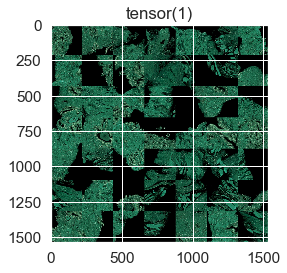

In [142]:
# version 1

if DEBUG:
    train_ds = MyTrainDataset(train_df, 'train', shuffle_df=True, shuffle_tiles=True, version=1)
    x, y = train_ds[0]
    print(x.shape)
    plt.imshow((x*0.5+0.5).permute(1, 2, 0).numpy())
    plt.title(y)

torch.Size([3, 1536, 1536])


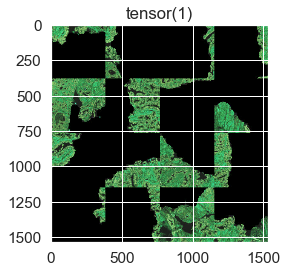

In [143]:
# version 2

if DEBUG:
    train_ds = MyTrainDataset(train_df, 'train', shuffle_df=True, shuffle_tiles=True, version=2)
    x, y = train_ds[0]
    print(x.shape)
    plt.imshow((x*0.5+0.5).permute(1, 2, 0).numpy())
    plt.title(y)

torch.Size([3, 1536, 1536])


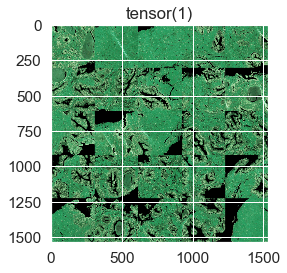

In [144]:
# version 3

if DEBUG:
    train_ds = MyTrainDataset(train_df, 'train', shuffle_df=True, shuffle_tiles=True, version=3)
    x, y = train_ds[0]
    print(x.shape)
    plt.imshow((x*0.5+0.5).permute(1, 2, 0).numpy())
    plt.title(y)

In [145]:
def get_data(version=1):
    train_ds = MyTrainDataset(train_df, 'train', shuffle_df=True, shuffle_tiles=True, version=version)
    train_dl = DataLoader(train_ds, batch_size=config.BS, shuffle=True, drop_last=True) # use 32 means 2 images per batch, don't shuffle to preserve 

    val_ds = MyTrainDataset(val_df, 'val', shuffle_df=False, shuffle_tiles=False, version=version)
    val_dl = DataLoader(val_ds, batch_size=config.BS, shuffle=False, drop_last=False)

    test_ds = MyTrainDataset(test_df, 'val', shuffle_df=False, shuffle_tiles=False, version=version)
    test_dl = DataLoader(test_ds, batch_size=config.BS, shuffle=False, drop_last=False)
    
    return train_dl, val_dl, test_dl

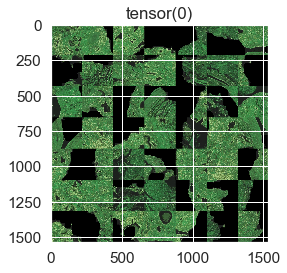

In [131]:
# test dl
train_dl, val_dl, test_dl = get_data(1)


if DEBUG:
    x, y = next(iter(train_dl))
    plt.imshow((x[0]*0.5+0.5).permute(1, 2, 0).numpy())
    plt.title(y[0])
 

del train_dl, val_dl, test_dl

# Model

In [132]:
from efficientnet_pytorch import EfficientNet

class MyModel(nn.Module):
    def __init__(self, backbone=f'efficientnet-b{V}'):
        super().__init__()
        
        self.base = EfficientNet.from_pretrained(backbone)
        self.fc = nn.Linear(self.base._fc.in_features, 1)
        self.base._fc = nn.Identity()
    
    def forward(self, x, y):
        x = self.base(x)
        x = self.fc(x) # [batch, 1]
        
        # get metrics
        y_preds = x.view(-1) #[batch,]
        loss = nn.MSELoss()(y_preds, y)
        return y_preds, loss

In [33]:
if DEBUG:
    model = MyModel()
    x = torch.randn(1, 3, 1536, 1536) 
    y = torch.ones(1,)
    y_preds, loss = model(x, y)
    print(y_preds, loss)
    
    del model, x, y, y_preds, loss

Loaded pretrained weights for efficientnet-b1
tensor([-0.1523], grad_fn=<ViewBackward>) tensor(1.3279, grad_fn=<MseLossBackward>)


In [133]:
model = MyModel()
ck = torch.load('./ckpts/efnb1-best-as-8622.pth', map_location=device)
model.load_state_dict(ck['state_dict'])
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=config.LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=5, verbose=1)

Loaded pretrained weights for efficientnet-b1


# Training

In [134]:
class OptimizedRounder():
    def __init__(self):
        self.coef_ = [0.5, 1.5, 2.5, 3.5, 4.5]

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 4
            else:
                X_p[i] = 5

        ll = cohen_kappa_score(y, X_p, weights='quadratic')

        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5, 4.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef=[0.5, 1.5, 2.5, 3.5, 4.5]):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 4
            else:
                X_p[i] = 5
        return X_p

    def coefficients(self):
        '''use after self.fit or error throws'''
        return self.coef_['x']

In [135]:
rounder = OptimizedRounder()

In [136]:
def train_on(epoch, train_dl):
    
    torch.cuda.empty_cache()
    gc.collect()
    
    # 
    model.train()
    optimizer.zero_grad() 
    
    loss_epoch = []
    preds_epoch = []
    y_epoch = []
    
    
    bar = tqdm(enumerate(train_dl), total=len(train_dl))
    for i, (x, y) in bar:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        y_preds, loss = model(x, y) # [batch,]  
        
        
        # update
        loss = loss / config.ACCUMULATION_STEP  # Normalize loss
        loss.backward() # calculate gradients
        if (i+1) % config.ACCUMULATION_STEP == 0:           
            optimizer.step()   # update weights                     
            optimizer.zero_grad()   # reset gradients                     
      

        # to numpy
        y_np = y.cpu().detach().numpy().astype(np.int)
#         y_preds_np = np.rint(y_preds.cpu().detach().numpy()).astype(np.int) # cannot do this or it would do 8 dimensions
        y_preds_np = rounder.predict(y_preds.cpu().detach().numpy()) # have do this
        loss_np = loss.cpu().detach().numpy()
        
        
        # add
        y_epoch.append(y_np)
        preds_epoch.append(y_preds_np)
        loss_epoch.append(loss_np)
    
        if (i+1) % 10 == 0:
            print(f'Step: {i}, y: {np.concatenate(y_epoch[(i-9):(i+1)])}, preds: {np.concatenate(preds_epoch[(i-9):(i+1)])}, loss: {np.mean(loss_epoch[(i-9):(i+1)]):.4f}')
        
        # clean
        del x, y, y_preds, loss, y_np, y_preds_np, loss_np
        torch.cuda.empty_cache()
        gc.collect()
        
        
    # cohen and confusion matrix
    cohen = cohen_kappa_score(np.concatenate(y_epoch), 
                              np.concatenate(preds_epoch),
                              weights='quadratic')
    loss = np.mean(loss_epoch)
    cm = confusion_matrix(np.concatenate(y_epoch), 
                          np.concatenate(preds_epoch))
    
    print('Epoch: %d, Loss: %.4f, Cohen: %.4f' % (epoch, loss, cohen))
    return loss, cohen, cm


In [137]:
torch.cuda.empty_cache()
gc.collect()

72

Step: 9, y: [0 0 5 1 5 1 0 0 3 0 0 4 3 2 0 2 3 1 3 2], preds: [0. 0. 4. 1. 2. 1. 0. 0. 3. 1. 1. 3. 4. 1. 0. 1. 3. 1. 4. 3.], loss: 0.2500
Step: 19, y: [0 1 3 1 5 0 0 1 5 0 1 1 0 5 2 0 0 1 2 0], preds: [0. 2. 3. 1. 5. 0. 0. 1. 4. 0. 1. 0. 0. 3. 2. 0. 0. 0. 1. 0.], loss: 0.1041
Step: 29, y: [4 2 4 0 3 1 1 4 0 0 0 0 1 1 1 4 5 0 1 5], preds: [3. 1. 3. 1. 2. 1. 1. 4. 0. 0. 0. 0. 1. 1. 1. 3. 4. 0. 1. 2.], loss: 0.1698
Step: 39, y: [1 1 2 0 3 0 5 3 4 2 1 0 0 1 1 1 0 0 5 1], preds: [0. 1. 1. 0. 4. 0. 3. 3. 3. 1. 1. 0. 0. 1. 1. 1. 0. 0. 4. 1.], loss: 0.0846
Step: 49, y: [0 3 0 4 1 0 4 1 5 0 1 1 1 3 4 2 1 0 0 2], preds: [0. 2. 1. 3. 1. 1. 4. 1. 5. 0. 0. 1. 2. 1. 5. 4. 1. 0. 0. 3.], loss: 0.1638
Step: 59, y: [4 0 3 5 2 1 0 0 1 3 4 3 0 4 5 1 5 1 1 3], preds: [5. 0. 4. 4. 2. 1. 0. 2. 3. 3. 3. 3. 0. 5. 5. 1. 5. 1. 1. 4.], loss: 0.1394
Step: 69, y: [2 0 4 5 1 3 1 3 0 2 2 1 5 4 2 4 1 1 1 4], preds: [4. 0. 4. 5. 1. 1. 1. 0. 2. 2. 2. 2. 5. 2. 4. 4. 1. 1. 1. 5.], loss: 0.4060
Step: 79, y: [0 5 1 1 1 2 1 

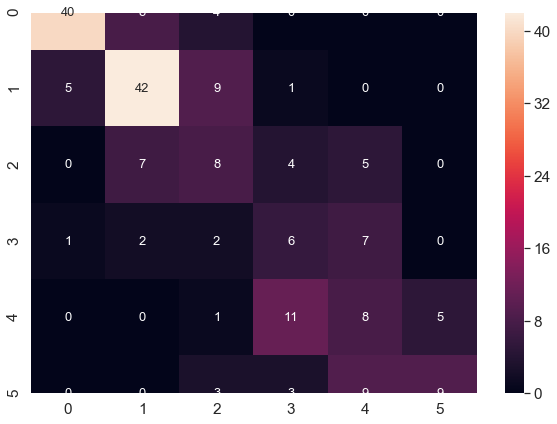

In [148]:
if True:
    train_dl, _, _ = get_data(version=3)
    _, _, train_cm = train_on(1, train_dl)
    
    # sometimes it would throw dimension not compatible error but I don't know why,
    # to circumvent this problem, just print it
    
    plot_confusion_matrix(train_cm, range(len(train_cm))) 
    

In [139]:
def val_on(epoch, dl):

    torch.cuda.empty_cache()
    gc.collect()
    
    model.eval()
    
    loss_epoch = []
    preds_epoch = []
    y_epoch = []
    bar = tqdm(enumerate(dl), total=len(dl))
    with torch.no_grad():
        for i, (x, y) in bar:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)
            
            y_preds, loss = model(x, y)

            # to numpy
            y_np = y.cpu().detach().numpy()
            y_preds_np = y_preds.cpu().detach().numpy()
            loss_np = loss.cpu().detach().numpy()
            
            
            # add
            y_epoch.append(y_np)
            preds_epoch.append(y_preds_np)
            loss_epoch.append(loss_np)
            
            bar.set_description(f'loss: {loss_np:.4f}')
        
            # clean
            del x, y, y_preds, loss, y_np, y_preds_np, loss_np
            torch.cuda.empty_cache()
            gc.collect()
            

    # cohen
    y_epoch = np.concatenate(y_epoch)
    preds_epoch = np.concatenate(preds_epoch)
    
    
    rounder.fit(preds_epoch, y_epoch)
    coef = rounder.coefficients()
    preds_epoch = rounder.predict(preds_epoch, coef)
    cohen = cohen_kappa_score(preds_epoch, y_epoch, weights='quadratic')
    
    loss = np.mean(loss_epoch)
    
    cm = confusion_matrix(y_epoch, 
                          preds_epoch)
    
    print('Epoch: %d, Loss: %.4f, Cohen: %.4f' % (epoch, loss, cohen))

    return loss, cohen, coef, cm
               


Epoch: 1, Loss: 1.1320, Cohen: 0.8006


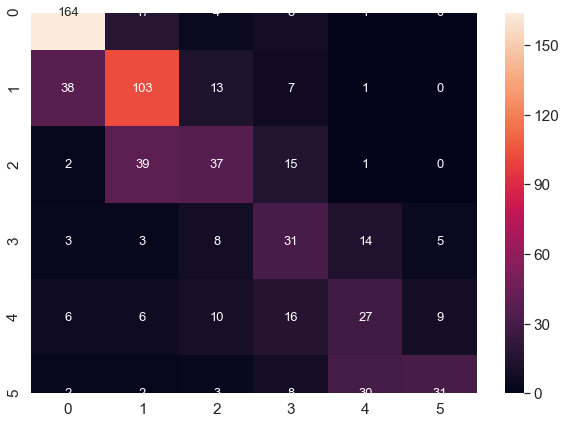

In [147]:
_, val_dl2, _ = get_data(version=3)
_, _, _, val_cm2 =  val_on(1, val_dl2)
plot_confusion_matrix(val_cm2, range(len(val_cm2)))


Epoch: 1, Loss: 0.9806, Cohen: 0.8581


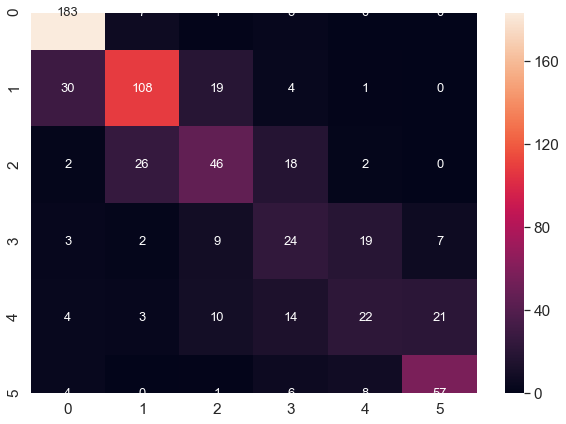


Epoch: 1, Loss: 4.0898, Cohen: 0.0205


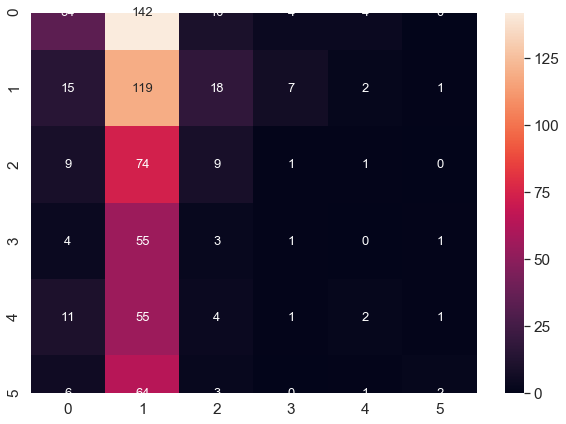


Epoch: 1, Loss: 0.9949, Cohen: 0.8352


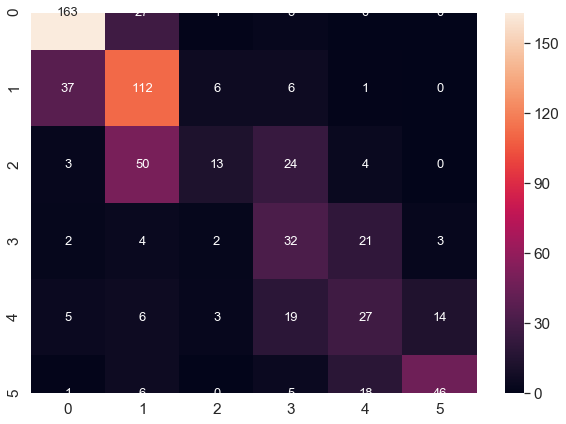

In [140]:
if DEBUG:
    _, val_dl1, _ = get_data(version=1)
    _, _, _, val_cm1 =  val_on(1, val_dl1)
    plot_confusion_matrix(val_cm1, range(len(val_cm1)))
    
    
    _, val_dl2, _ = get_data(version=2)
    _, _, _, val_cm2 =  val_on(1, val_dl2)
    plot_confusion_matrix(val_cm2, range(len(val_cm2)))
    
    
    _, val_dl3, _ = get_data(version=3)
    _, _, _, val_cm3 =  val_on(1, val_dl3)
    plot_confusion_matrix(val_cm3, range(len(val_cm3)))


In [44]:
# should be put outside 
best_cohen = 0. # last best score

In [45]:
def train(epochs, train_dl, val_dl):
    global best_cohen
    
    for e in range(epochs):
        
        train_loss, train_cohen, train_cm = train_on(e, train_dl)
        plot_confusion_matrix(train_cm)
        val_loss, val_cohen, coef, val_cm = val_on(e, val_dl)
        plot_confusion_matrix(val_cm)
        
        # adjust lr
        scheduler.step(val_loss)

        # show
        print(f'Epoch: {e}, Train loss: {(train_loss):.4f}, Train cohen: {(train_cohen):.4f}\n   Val loss: {(val_loss):.4f}, Val cohen:{(val_cohen):.4f}, Coef: {coef} \n\n')
        
    
        # save best
        if val_cohen >= best_cohen:
            print('save best model')
            save_model(f'efnb{V}-best.pth')
            best_cohen = val_cohen
           
        
        save_model(f'./efnb{V}-{e}.pth')
     
    save_model(f'./efnb{V}-final.pth')
              
        

In [46]:
torch.cuda.empty_cache()
gc.collect()

5766

Step: 9, y: [0 2 0 1 0 1 0 1 0 2 3 1 2 5 4 0 1 4 5 3], preds: [3. 1. 1. 1. 2. 1. 0. 2. 0. 3. 4. 3. 2. 4. 4. 2. 0. 4. 2. 4.], loss: 0.4789
Step: 19, y: [0 2 0 4 1 4 4 3 0 1 4 0 0 1 2 4 5 0 0 1], preds: [1. 2. 0. 5. 1. 3. 4. 2. 1. 2. 4. 1. 0. 0. 4. 3. 1. 1. 1. 1.], loss: 0.3869
Step: 29, y: [5 0 0 1 2 1 3 5 1 1 2 1 3 2 0 3 4 5 1 0], preds: [3. 1. 1. 1. 3. 1. 2. 4. 1. 2. 3. 2. 0. 2. 0. 3. 2. 4. 3. 1.], loss: 0.3390
Step: 39, y: [2 3 1 1 1 0 3 2 1 1 1 0 5 1 1 0 5 5 4 2], preds: [2. 0. 1. 2. 2. 0. 2. 3. 1. 1. 1. 0. 4. 2. 1. 0. 1. 2. 0. 2.], loss: 0.6368
Step: 49, y: [0 4 5 4 0 1 0 2 1 5 4 5 3 5 4 5 1 1 2 1], preds: [1. 3. 1. 4. 0. 1. 0. 2. 2. 4. 1. 2. 4. 5. 1. 4. 2. 1. 1. 1.], loss: 0.6335
Step: 59, y: [3 2 3 0 1 3 3 5 1 1 1 0 0 2 1 0 0 5 2 0], preds: [2. 3. 1. 1. 2. 3. 0. 2. 1. 2. 1. 0. 2. 3. 1. 2. 1. 5. 3. 1.], loss: 0.5390
Step: 69, y: [0 1 3 2 0 1 0 3 1 3 0 1 4 0 0 1 2 3 2 5], preds: [1. 1. 3. 2. 0. 1. 0. 4. 1. 3. 1. 1. 1. 1. 2. 1. 2. 1. 3. 3.], loss: 0.3786
Step: 79, y: [1 5 1 0 2 4 1 

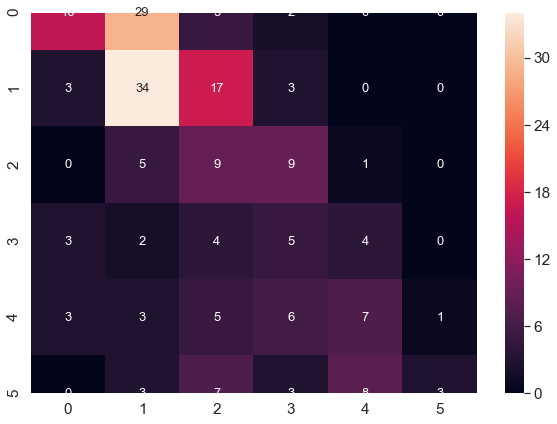


Epoch: 0, Loss: 1.9462, Cohen: 0.6115


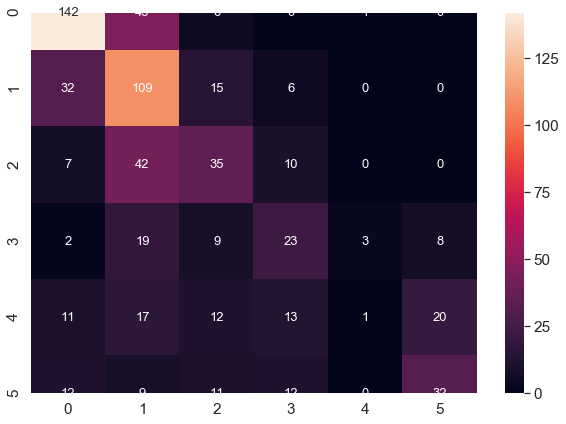

Epoch: 0, Train loss: 0.4647, Train cohen: 0.5678
   Val loss: 1.9462, Val cohen:0.6115, Coef: [0.47057893 1.64901314 2.37314596 3.40758757 3.47596554] 


save best model


Step: 9, y: [3 1 0 0 1 4 3 1 0 4 1 4 1 2 3 1 0 0 1 4], preds: [4. 2. 1. 1. 1. 3. 4. 1. 1. 2. 1. 2. 1. 2. 2. 2. 1. 1. 1. 4.], loss: 0.2433
Step: 19, y: [4 1 4 0 2 2 0 2 2 4 1 5 2 5 4 0 3 0 1 0], preds: [2. 1. 2. 1. 1. 2. 0. 3. 3. 4. 2. 5. 3. 3. 1. 2. 3. 1. 2. 2.], loss: 0.5282
Step: 29, y: [2 5 2 0 1 1 0 0 1 2 4 2 1 1 5 5 1 1 4 2], preds: [3. 4. 1. 1. 1. 1. 1. 0. 2. 1. 1. 1. 1. 1. 3. 3. 3. 1. 3. 1.], loss: 0.3622
Step: 39, y: [1 1 4 0 1 3 3 3 3 0 5 4 3 3 1 0 1 4 2 2], preds: [1. 1. 4. 1. 1. 0. 3. 1. 3. 2. 4. 3. 4. 2. 2. 1. 1. 1. 2. 2.], loss: 0.3362
Step: 49, y: [0 1 4 1 1 2 0 1 2 1 1 1 3 3 2 0 0 1 0 0], preds: [1. 2. 3. 2. 1. 3. 1. 1. 2. 1. 1. 1. 3. 2. 2. 1. 1. 2. 1. 1.], loss: 0.1261
Step: 59, y: [0 3 1 0 0 0 5 1 0 1 5 5 0 5 0 5 1 0 2 0], preds: [1. 3. 1. 1. 1. 1. 1. 3. 1. 1. 2. 2. 1. 5. 1. 4. 1. 1. 2. 1.], loss: 0.5945
Step: 69, y: [2 1 1 5 5 5 2 0 4 4 1 4 0 1 3 1 1 2 0 0], preds: [3. 1. 1. 3. 2. 4. 3. 1. 3. 3. 2. 4. 1. 2. 3. 2. 1. 3. 1. 1.], loss: 0.3388
Step: 79, y: [1 5 2 5 0 1 1 

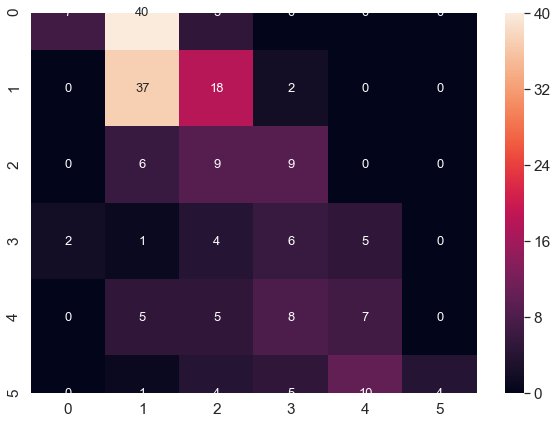


Epoch: 1, Loss: 1.3098, Cohen: 0.7535


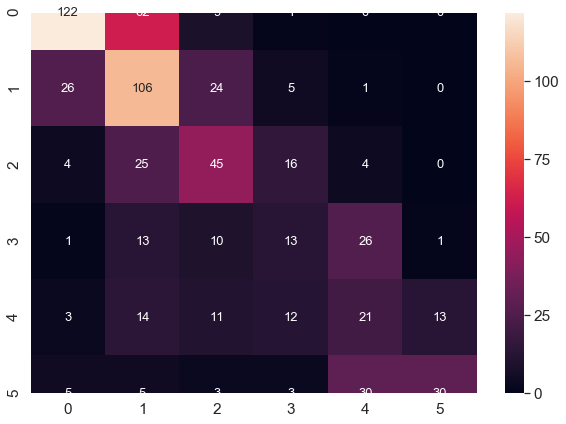

Epoch: 1, Train loss: 0.3459, Train cohen: 0.6718
   Val loss: 1.3098, Val cohen:0.7535, Coef: [0.51729107 1.54242922 2.56699136 3.17167312 4.44373517] 


save best model


Step: 9, y: [0 1 2 0 1 0 0 0 1 0 1 3 0 1 4 1 0 1 4 4], preds: [0. 2. 2. 2. 2. 1. 1. 1. 1. 0. 1. 4. 1. 2. 4. 1. 1. 1. 3. 1.], loss: 0.2287
Step: 19, y: [5 3 5 1 0 1 1 0 5 1 5 0 0 0 5 0 4 0 2 5], preds: [4. 3. 4. 2. 1. 1. 2. 1. 3. 2. 3. 3. 0. 1. 3. 0. 3. 1. 2. 5.], loss: 0.3803
Step: 29, y: [0 0 1 0 4 1 2 5 4 1 5 0 2 3 0 0 1 1 4 5], preds: [0. 1. 1. 1. 0. 1. 1. 2. 3. 1. 5. 1. 3. 3. 0. 1. 1. 3. 4. 3.], loss: 0.3698
Step: 39, y: [3 0 0 0 2 3 4 1 0 0 1 1 5 1 0 5 0 2 2 4], preds: [0. 0. 0. 0. 1. 4. 3. 2. 1. 1. 1. 1. 5. 1. 0. 1. 0. 1. 3. 4.], loss: 0.3454
Step: 49, y: [3 1 1 3 0 0 5 2 0 2 1 3 2 0 0 5 3 4 3 5], preds: [0. 1. 0. 4. 0. 2. 2. 2. 0. 3. 1. 1. 2. 1. 1. 5. 3. 3. 2. 1.], loss: 0.5995
Step: 59, y: [2 1 1 1 0 1 1 4 1 4 4 5 1 2 4 0 2 2 3 0], preds: [3. 1. 1. 1. 0. 1. 1. 4. 2. 3. 4. 3. 1. 2. 4. 0. 1. 4. 4. 1.], loss: 0.1691
Step: 69, y: [5 2 4 0 4 3 5 0 1 2 0 0 1 0 1 0 1 0 0 1], preds: [5. 2. 4. 1. 4. 2. 5. 1. 1. 2. 0. 1. 0. 3. 1. 1. 1. 1. 2. 1.], loss: 0.2401
Step: 79, y: [1 1 1 1 2 3 0 

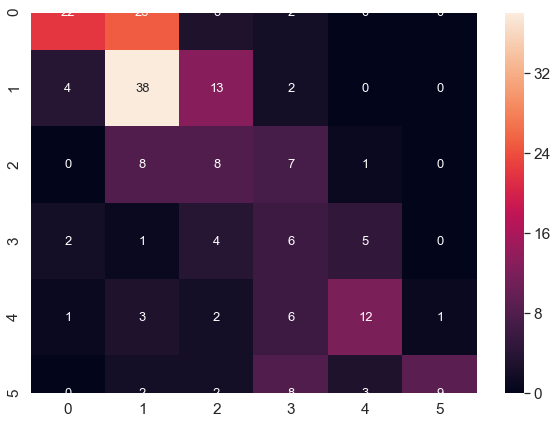


Epoch: 2, Loss: 1.3318, Cohen: 0.7377


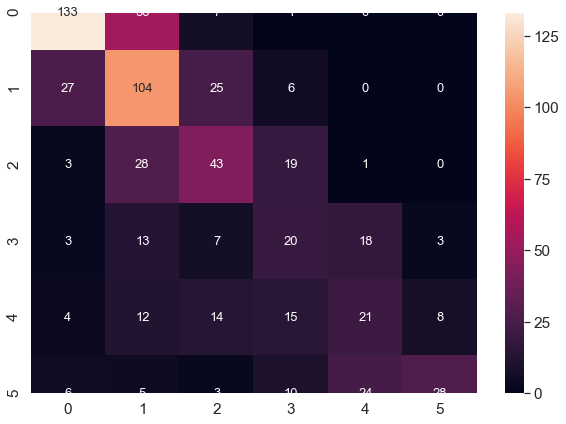

Epoch: 2, Train loss: 0.3140, Train cohen: 0.7243
   Val loss: 1.3318, Val cohen:0.7377, Coef: [0.5009375 1.5028125 2.5046875 3.4890625 4.5084375] 




Step: 9, y: [1 2 2 3 2 1 1 2 1 0 2 1 0 3 0 1 3 0 1 0], preds: [1. 2. 2. 3. 1. 1. 1. 2. 1. 0. 1. 3. 0. 2. 1. 1. 3. 0. 1. 0.], loss: 0.0806
Step: 19, y: [0 3 5 1 1 1 1 2 1 1 4 4 5 2 1 4 0 0 4 2], preds: [0. 3. 3. 0. 1. 1. 1. 1. 2. 1. 2. 3. 3. 1. 1. 4. 0. 0. 2. 4.], loss: 0.2657
Step: 29, y: [5 1 5 2 5 1 5 1 0 1 0 2 1 2 4 1 4 0 5 0], preds: [3. 1. 5. 4. 4. 1. 4. 2. 0. 1. 1. 2. 1. 1. 3. 1. 2. 1. 4. 1.], loss: 0.1918
Step: 39, y: [4 4 3 0 5 3 1 0 5 1 4 4 4 4 3 4 4 5 5 1], preds: [0. 5. 2. 1. 4. 1. 1. 0. 2. 1. 2. 3. 3. 2. 4. 4. 4. 3. 5. 2.], loss: 0.5747
Step: 49, y: [1 4 1 0 5 1 0 0 4 5 3 2 0 3 1 2 1 0 3 5], preds: [2. 4. 1. 0. 3. 2. 1. 2. 3. 3. 4. 2. 1. 1. 2. 2. 1. 1. 3. 4.], loss: 0.3191
Step: 59, y: [4 5 0 0 2 5 3 2 4 0 1 5 1 5 0 0 0 0 2 5], preds: [4. 5. 3. 1. 1. 5. 1. 2. 4. 1. 2. 5. 1. 2. 1. 2. 1. 1. 4. 4.], loss: 0.4441
Step: 69, y: [0 0 1 3 3 0 2 0 0 1 5 2 5 0 1 0 5 0 0 0], preds: [1. 1. 3. 4. 3. 2. 3. 1. 0. 2. 5. 3. 5. 1. 2. 4. 4. 1. 0. 1.], loss: 0.4025
Step: 79, y: [1 3 0 4 4 0 1 

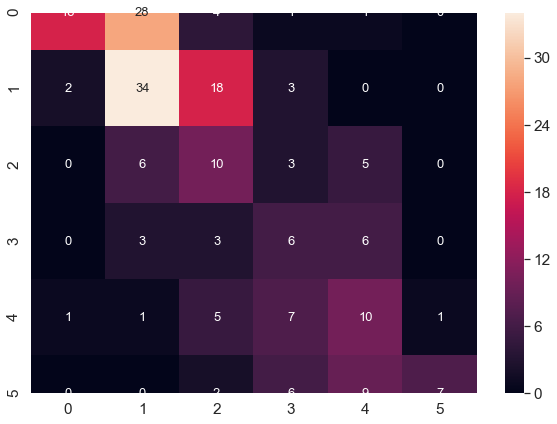


Epoch: 3, Loss: 1.3348, Cohen: 0.7615


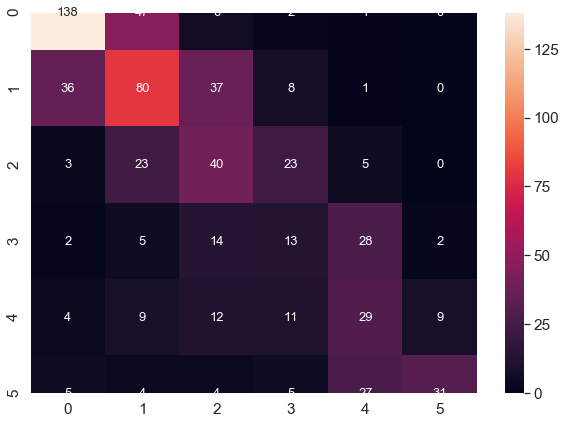

Epoch: 3, Train loss: 0.2838, Train cohen: 0.7389
   Val loss: 1.3348, Val cohen:0.7615, Coef: [0.54299843 1.37562496 2.46791757 3.31257461 4.77429213] 


save best model


Step: 9, y: [0 1 5 1 1 0 2 2 4 2 1 0 3 1 0 4 1 3 2 5], preds: [0. 1. 4. 1. 1. 1. 3. 2. 3. 3. 1. 1. 2. 1. 0. 5. 1. 3. 1. 5.], loss: 0.0975
Step: 19, y: [1 5 5 2 4 1 5 5 1 5 0 4 1 1 4 1 1 0 1 0], preds: [2. 3. 3. 1. 2. 1. 4. 3. 1. 2. 1. 4. 1. 1. 2. 1. 1. 0. 0. 1.], loss: 0.4678
Step: 29, y: [0 4 0 1 5 5 0 4 0 1 4 1 0 2 0 2 3 5 1 2], preds: [0. 3. 2. 1. 3. 4. 0. 2. 1. 2. 1. 0. 1. 1. 0. 1. 3. 3. 3. 2.], loss: 0.4489
Step: 39, y: [4 2 2 0 3 0 0 0 0 2 0 3 0 0 1 5 3 5 0 2], preds: [2. 3. 1. 1. 3. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 5. 4. 5. 0. 4.], loss: 0.2172
Step: 49, y: [1 0 4 0 1 3 0 2 1 5 0 2 3 4 1 1 5 1 0 1], preds: [1. 0. 5. 1. 1. 3. 1. 1. 1. 5. 0. 2. 3. 5. 1. 1. 4. 2. 1. 3.], loss: 0.0988
Step: 59, y: [0 3 1 0 1 5 5 4 4 2 4 1 5 1 0 1 4 5 1 3], preds: [1. 3. 1. 0. 1. 4. 3. 2. 3. 2. 3. 1. 5. 1. 1. 1. 1. 5. 1. 3.], loss: 0.3490
Step: 69, y: [1 1 1 0 0 0 0 2 5 1 4 3 0 4 1 1 1 2 0 0], preds: [2. 1. 1. 1. 1. 1. 0. 2. 5. 2. 4. 3. 1. 4. 1. 1. 1. 3. 0. 0.], loss: 0.0709
Step: 79, y: [1 4 3 0 4 0 2 

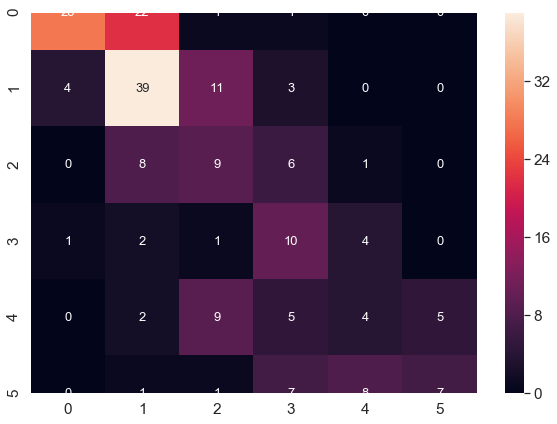


Epoch: 4, Loss: 1.3726, Cohen: 0.7691


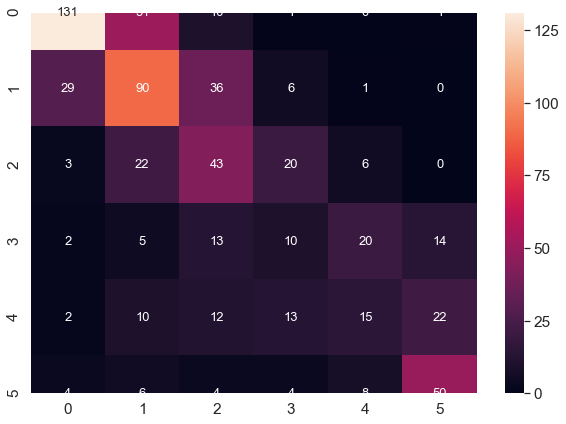

Epoch: 4, Train loss: 0.2699, Train cohen: 0.7741
   Val loss: 1.3726, Val cohen:0.7691, Coef: [0.56072416 1.57100694 2.70288122 3.452145   4.15511926] 


save best model


Step: 9, y: [3 0 3 5 2 4 1 1 4 2 0 0 4 4 4 1 0 1 1 0], preds: [4. 0. 3. 5. 2. 4. 1. 1. 4. 1. 0. 0. 4. 5. 5. 2. 0. 1. 1. 0.], loss: 0.0769
Step: 19, y: [0 0 1 1 1 5 2 4 1 4 1 0 0 0 4 1 4 3 1 1], preds: [1. 0. 2. 0. 2. 4. 2. 5. 0. 3. 2. 1. 0. 1. 4. 1. 3. 3. 2. 1.], loss: 0.1249
Step: 29, y: [1 1 0 1 0 0 0 4 1 0 2 4 5 4 2 5 2 0 1 1], preds: [2. 1. 2. 1. 1. 1. 1. 3. 2. 1. 3. 3. 5. 2. 1. 1. 2. 1. 2. 1.], loss: 0.4554
Step: 39, y: [5 1 1 0 1 5 0 1 1 1 0 1 4 2 5 3 5 1 1 2], preds: [5. 1. 2. 0. 1. 3. 1. 1. 1. 1. 1. 1. 1. 2. 5. 2. 2. 1. 1. 1.], loss: 0.3624
Step: 49, y: [0 1 0 1 0 4 1 3 4 0 3 1 1 0 5 3 0 2 5 1], preds: [0. 2. 1. 1. 1. 2. 2. 4. 3. 1. 3. 1. 1. 1. 4. 2. 0. 1. 1. 1.], loss: 0.3431
Step: 59, y: [1 2 1 0 5 3 1 0 4 1 5 5 0 0 4 4 3 0 2 1], preds: [1. 3. 2. 1. 3. 2. 1. 0. 2. 1. 4. 3. 0. 0. 3. 3. 3. 1. 2. 2.], loss: 0.2644
Step: 69, y: [3 1 1 0 1 1 0 1 0 0 3 4 0 3 2 5 3 0 5 2], preds: [3. 1. 1. 2. 0. 1. 0. 1. 1. 1. 2. 3. 1. 2. 2. 3. 2. 0. 4. 2.], loss: 0.2022
Step: 79, y: [0 1 2 0 0 1 0 

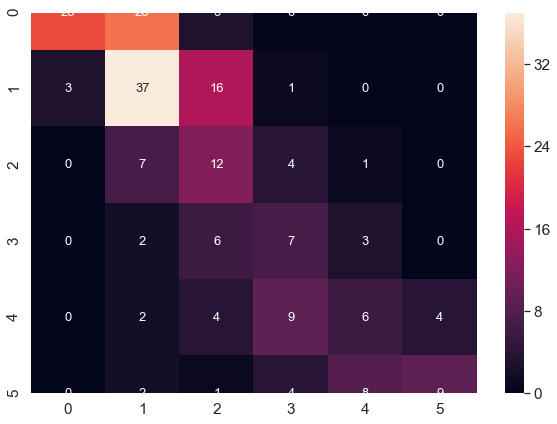


Epoch: 5, Loss: 1.3726, Cohen: 0.7703


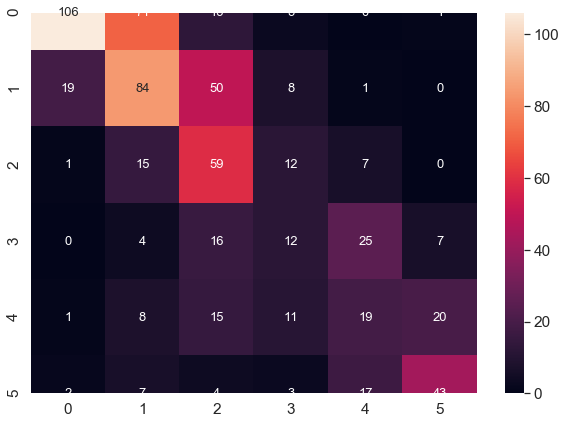

Epoch: 5, Train loss: 0.2477, Train cohen: 0.7923
   Val loss: 1.3726, Val cohen:0.7703, Coef: [0.48471418 1.49866905 2.83045932 3.40161884 4.44931449] 


save best model


Step: 9, y: [1 1 1 5 0 1 2 4 1 2 1 0 1 1 0 1 4 0 0 3], preds: [1. 2. 1. 4. 0. 2. 2. 4. 1. 2. 1. 1. 2. 1. 0. 2. 2. 1. 1. 3.], loss: 0.1688
Step: 19, y: [0 2 3 0 3 1 3 0 0 0 0 1 4 0 3 1 0 1 0 1], preds: [1. 2. 2. 0. 5. 1. 4. 2. 1. 0. 1. 1. 4. 1. 3. 2. 1. 2. 2. 2.], loss: 0.2500
Step: 29, y: [3 1 5 4 0 5 4 1 1 0 0 5 0 0 2 0 0 5 2 0], preds: [2. 1. 4. 2. 0. 5. 4. 1. 2. 1. 1. 4. 1. 1. 2. 0. 0. 4. 3. 1.], loss: 0.1795
Step: 39, y: [1 0 4 2 0 1 4 3 1 0 5 1 1 1 2 4 0 5 2 1], preds: [1. 0. 0. 2. 0. 1. 4. 1. 2. 0. 5. 2. 1. 1. 3. 4. 1. 5. 2. 1.], loss: 0.2426
Step: 49, y: [1 5 1 0 1 1 2 0 1 4 4 0 2 5 1 0 5 4 0 3], preds: [1. 3. 0. 1. 1. 0. 2. 0. 2. 2. 2. 1. 2. 5. 0. 0. 5. 4. 0. 3.], loss: 0.1685
Step: 59, y: [2 4 1 4 1 2 4 1 2 0 4 1 0 3 0 1 4 3 0 3], preds: [1. 1. 1. 5. 1. 2. 3. 1. 1. 0. 1. 1. 0. 3. 0. 1. 3. 1. 0. 3.], loss: 0.3318
Step: 69, y: [1 5 0 1 0 5 1 1 1 0 5 3 0 2 0 1 4 1 3 1], preds: [1. 4. 1. 1. 0. 4. 1. 1. 1. 0. 5. 3. 0. 3. 0. 2. 5. 1. 1. 1.], loss: 0.1198
Step: 79, y: [1 1 4 2 1 2 5 

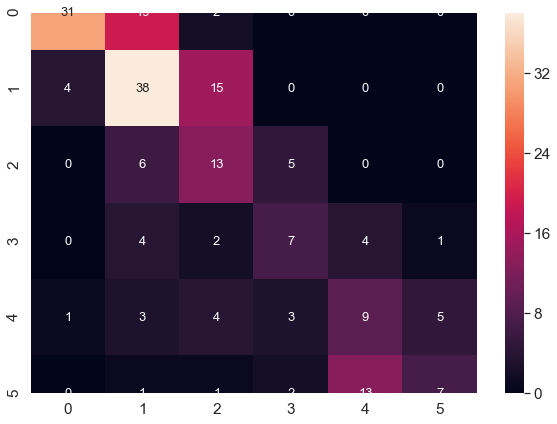


Epoch: 6, Loss: 1.3685, Cohen: 0.7618


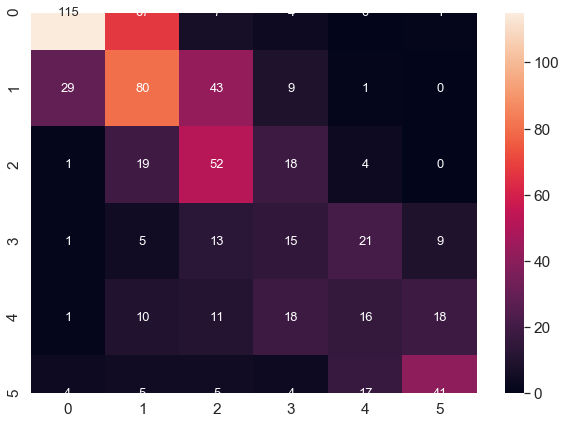

Epoch: 6, Train loss: 0.2223, Train cohen: 0.8124
   Val loss: 1.3685, Val cohen:0.7618, Coef: [0.50192568 1.48596267 2.51238036 3.39229017 4.56272365] 




Step: 9, y: [4 5 5 0 0 4 3 0 4 3 2 1 1 1 0 0 2 0 2 1], preds: [3. 5. 4. 1. 0. 3. 4. 0. 3. 3. 3. 1. 2. 2. 1. 4. 2. 1. 2. 1.], loss: 0.2927
Step: 19, y: [2 0 1 1 0 0 1 3 5 5 0 0 0 4 2 1 1 4 5 0], preds: [1. 0. 1. 1. 1. 0. 2. 4. 3. 4. 0. 1. 0. 4. 2. 0. 1. 4. 4. 1.], loss: 0.1684
Step: 29, y: [2 3 1 0 0 1 2 2 0 1 4 5 2 1 0 4 1 0 1 1], preds: [3. 4. 1. 1. 0. 2. 2. 1. 0. 0. 4. 4. 3. 1. 1. 3. 3. 0. 2. 1.], loss: 0.1346
Step: 39, y: [0 1 1 4 1 4 3 3 0 5 5 2 2 0 0 0 3 0 1 5], preds: [1. 1. 1. 4. 1. 4. 4. 1. 0. 3. 4. 2. 3. 0. 0. 1. 4. 0. 2. 4.], loss: 0.2133
Step: 49, y: [2 1 1 0 0 4 0 0 2 5 2 3 4 0 5 1 5 0 0 4], preds: [3. 3. 1. 1. 0. 4. 1. 0. 1. 4. 2. 4. 2. 0. 4. 1. 5. 0. 0. 4.], loss: 0.1446
Step: 59, y: [0 1 1 0 3 1 4 5 0 2 1 2 5 0 3 4 0 1 4 3], preds: [0. 1. 1. 1. 4. 2. 1. 2. 1. 2. 1. 3. 4. 1. 4. 4. 1. 2. 2. 3.], loss: 0.3966
Step: 69, y: [2 1 5 3 3 1 1 1 5 0 5 2 0 0 1 1 0 1 4 1], preds: [3. 1. 5. 3. 2. 1. 1. 1. 5. 1. 4. 2. 1. 0. 1. 1. 1. 1. 4. 2.], loss: 0.0777
Step: 79, y: [0 4 5 5 4 0 1 

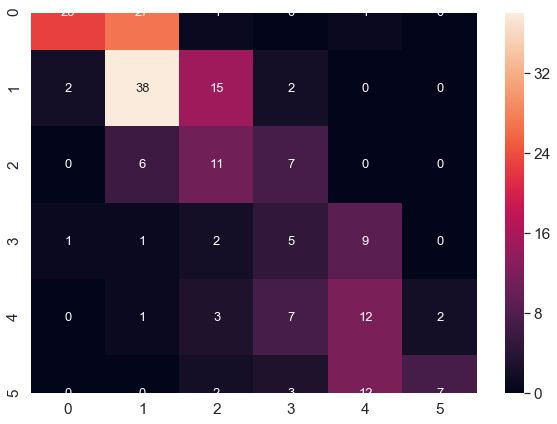


Epoch: 7, Loss: 1.3522, Cohen: 0.7674


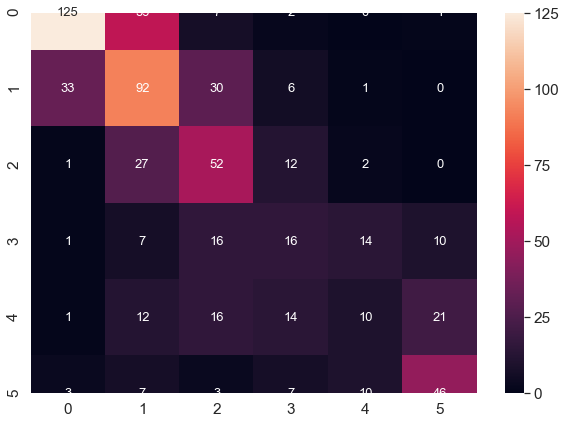

Epoch     8: reducing learning rate of group 0 to 2.0000e-05.
Epoch: 7, Train loss: 0.2048, Train cohen: 0.8218
   Val loss: 1.3522, Val cohen:0.7674, Coef: [0.50253617 1.54824292 2.72573746 3.55883555 4.19206298] 




Step: 9, y: [1 0 1 2 4 2 0 1 0 1 2 2 1 0 1 5 2 0 5 3], preds: [1. 1. 1. 2. 5. 1. 1. 2. 1. 2. 3. 2. 0. 1. 1. 4. 2. 0. 5. 2.], loss: 0.1306
Step: 19, y: [3 1 5 0 4 1 1 5 1 5 0 2 1 1 1 0 2 5 4 0], preds: [3. 1. 4. 1. 5. 2. 1. 5. 1. 4. 0. 2. 1. 1. 2. 0. 1. 5. 3. 1.], loss: 0.0984
Step: 29, y: [4 4 2 3 1 1 5 1 2 4 0 3 3 0 5 3 2 1 0 5], preds: [3. 4. 3. 1. 1. 1. 4. 0. 2. 4. 0. 4. 3. 1. 5. 3. 2. 1. 0. 5.], loss: 0.1484
Step: 39, y: [1 3 2 2 1 3 4 1 1 4 0 2 0 2 2 1 0 2 0 0], preds: [1. 2. 2. 1. 2. 3. 2. 1. 2. 3. 0. 1. 0. 3. 2. 1. 1. 2. 3. 0.], loss: 0.1898
Step: 49, y: [0 1 5 5 4 1 5 2 0 0 5 0 1 1 3 4 4 1 0 1], preds: [1. 2. 4. 3. 5. 1. 4. 2. 0. 2. 5. 1. 1. 2. 1. 5. 5. 1. 0. 2.], loss: 0.2372
Step: 59, y: [1 4 1 0 5 4 1 2 4 0 0 1 4 2 3 1 0 1 3 0], preds: [3. 3. 1. 0. 2. 1. 1. 2. 3. 0. 0. 2. 3. 2. 4. 1. 0. 1. 3. 1.], loss: 0.3011
Step: 69, y: [1 1 1 3 3 1 0 1 0 4 1 1 1 0 4 5 1 2 0 1], preds: [1. 1. 1. 4. 3. 1. 0. 1. 0. 4. 2. 1. 1. 0. 5. 4. 2. 3. 1. 1.], loss: 0.0643
Step: 79, y: [2 3 2 0 5 5 1 

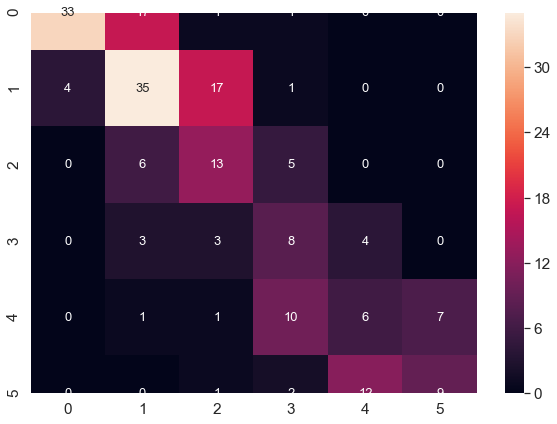


Epoch: 8, Loss: 1.3868, Cohen: 0.7756


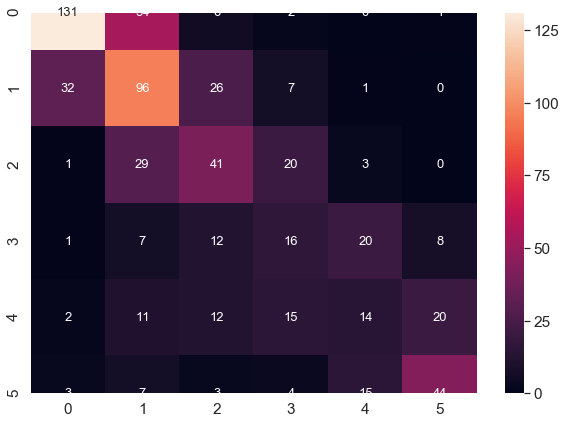

Epoch: 8, Train loss: 0.1605, Train cohen: 0.8647
   Val loss: 1.3868, Val cohen:0.7756, Coef: [0.4972178  1.59577216 2.53492243 3.4891911  4.49094277] 


save best model


Step: 9, y: [0 0 3 4 2 1 0 1 2 2 4 0 5 0 1 2 1 1 1 4], preds: [0. 1. 2. 4. 3. 1. 1. 2. 2. 2. 3. 0. 4. 0. 1. 2. 1. 1. 1. 4.], loss: 0.0854
Step: 19, y: [3 1 1 5 2 0 2 5 4 4 1 4 1 0 5 5 0 0 1 0], preds: [4. 1. 1. 5. 2. 0. 1. 5. 3. 4. 1. 4. 2. 0. 4. 4. 1. 1. 1. 1.], loss: 0.0920
Step: 29, y: [1 3 0 1 0 0 0 2 5 5 4 1 0 4 1 1 5 1 0 0], preds: [1. 2. 0. 2. 1. 0. 1. 2. 2. 5. 5. 1. 0. 5. 2. 0. 4. 3. 1. 0.], loss: 0.2342
Step: 39, y: [0 5 0 1 3 4 1 0 4 0 1 3 0 3 1 5 1 0 5 1], preds: [1. 3. 0. 1. 2. 1. 1. 0. 5. 1. 2. 3. 0. 1. 1. 3. 1. 0. 5. 1.], loss: 0.3245
Step: 49, y: [4 1 0 0 1 5 0 0 3 0 2 3 3 1 0 1 5 1 0 1], preds: [4. 1. 1. 0. 1. 5. 0. 1. 4. 1. 2. 4. 3. 1. 0. 1. 5. 1. 0. 2.], loss: 0.0795
Step: 59, y: [4 2 0 5 4 0 1 1 4 5 2 1 2 4 3 0 0 1 1 2], preds: [4. 1. 1. 4. 5. 0. 1. 1. 3. 5. 1. 1. 1. 3. 4. 0. 0. 0. 1. 2.], loss: 0.1077
Step: 69, y: [0 3 1 3 1 0 2 1 5 4 1 3 5 0 2 4 0 2 0 4], preds: [0. 1. 3. 3. 1. 0. 1. 1. 4. 2. 1. 4. 3. 0. 4. 4. 0. 2. 0. 3.], loss: 0.2597
Step: 79, y: [3 2 5 1 2 2 0 

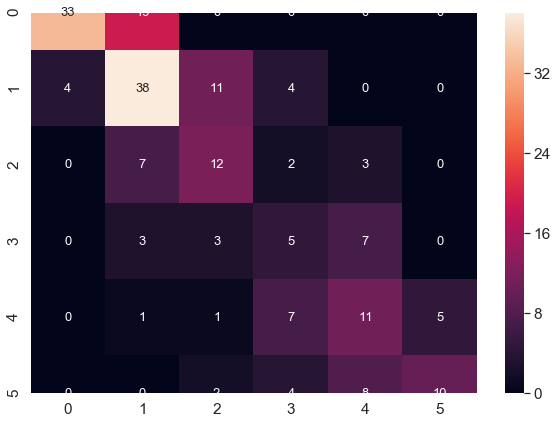


Epoch: 9, Loss: 1.3785, Cohen: 0.7775


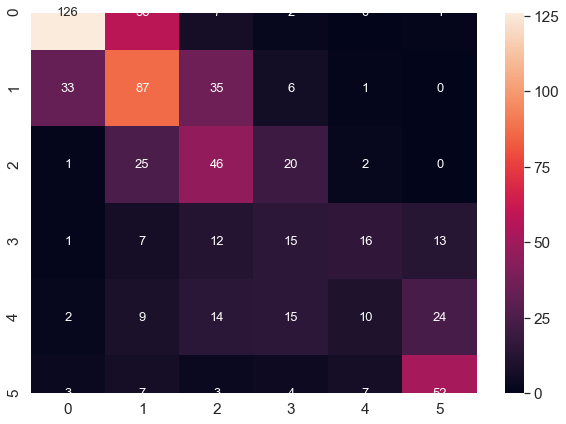

Epoch: 9, Train loss: 0.1793, Train cohen: 0.8525
   Val loss: 1.3785, Val cohen:0.7775, Coef: [0.50705459 1.53789154 2.66709294 3.58325638 4.20101225] 


save best model


In [149]:
# 1
train_dl, val_dl, test_dl = get_data(2)
train(10, train_dl, val_dl)

In [158]:
pred_df = pd.read_csv('/Users/dph/downloads/pred_df.csv')
labels = pred_df['isup_grade'][:50]
preds = pred_df['pred_3_a'][:50]
cohen = cohen_kappa_score(labels, preds, weights='quadratic')
cohen

-0.10328956274536338